# Representing prior knowledge: postcodes

France's *La Poste* has used automated sorting since 1964. Handwritten digit recognition has been well studied. In order to use digit recognition in practice for sorting mail, we need a *prior* model for how probable each postcode is, independent of each actual digitized hand-written digit image in front of us.

A sample of some international postcodes:
- 2000 (Sydney)
- 3122 (Hawthorn, VIC)
- 4350 (used for 44 towns near Toowoomba, QLD)
- A-1220 (Vienna, Austria)
- Tsuen Wan (Hong Kong): no postcodes in HK
- 02138 (Cambridge, MA)
- EC1V 4AD (London)
- 8007 (PO boxes in Collins Street West)

## A prior for Australian postcodes

What prior information?

- Do all Australian postcodes have 4 digits? Yes.
- What range? 0200 to 9944
- What proportion of mail our system sees is for Australia versus overseas? 80% (assumed)
- 25% (assumed) of all mail goes to these 10 postcodes: 2000, 2001, 3000, 3001, 4000, 4001, 5000, 5001, 6000, 6001.
- What population for each postcode? (and how to handle this when e.g. Paramatta NSW has 2150 for street addresses and 2124 for postcodes). If we don't have population info by postcode, how about using a prior with state population data?
- States:
   - NSW: postcodes 1000-1999 (PO boxes), 2000-2599, 2620-2899, 2921-2999
   - ACT: 0200-0299 (PO boxes), 2600-2619, 2900-2920
   - VIC: 3000-3999, 8000-8999 (PO boxes)
   - QLD: 4000-4999, 9000-9999 (PO boxes)
   - SA: 5000-5799, 5800-5999 (PO boxes)
   - WA 6000-6797, 6800-6999 (PO boxes)
   - TAS: 7000-7799, 7800-7999 (PO boxes)
   - NT: 0800-0899, 0900-0999 (PO boxes)
- Within each state xxxx, 80% of mail goes to x0xx and x1xx (metropolitan city areas and suburbs).

### How do we encode this prior information for machine learning purposes?

In [1]:
postcodes_by_state = dict((
    ('Australian Capital Territory', set(range(2600, 2620)) | set(range(2900, 2920))),
    ('New South Wales', set(range(2000, 3000)) - set(range(2600, 2620)) - set(range(2900, 2920))),
    ('Victoria', set(range(3000, 4000))),
    ('Queensland', set(range(4000, 5000))),
    ('South Australia', set(range(5000, 5800))),
    ('Western Australia', set(range(6000, 6798))),
    ('Tasmania', set(range(7000, 7800))),
    ('Northern Territory', set(range(800, 900)))
))

### Goal: construct a prior $p(\textrm{postcode})$ over all 4-digit postcodes

We will start by using state populations as a proxy for really knowing the proportion of mail sent to each postcode. (If we obtain more data, we can update and improve our model by applying Bayes' theorem later.)

#### State populations

In [2]:
import pandas as pd

In [3]:
def fetch_state_populations():
    url = 'http://www.ausstats.abs.gov.au/Ausstats/subscriber.nsf/0/D52DEAAFCEDF7B2ACA2580EB00133359/$File/31010do001_201609.xls'

    state_populations = pd.read_excel(url, sheet_name='Table_8', skiprows=6,
                  names=['State', 'Population', '%'])

    state_populations.set_index('State', inplace=True)

    drop_row_idx = list(state_populations.index).index('Other Territories')

    state_populations.drop(state_populations.index[drop_row_idx:], inplace=True)

    state_populations['Population'] = state_populations['Population'].astype(int)
    # state_populations.to_hdf('state_populations.h5', key='populations')
    return state_populations

In [6]:
state_populations = fetch_state_populations()

In [5]:
# state_populations = pd.read_hdf('aus_state_populations.h5')

In [7]:
state_populations

,Population,%
State,,
New South Wales,7757843,32.0
Victoria,6100877,25.2
Queensland,4860448,20.1
South Australia,1710804,7.1
Western Australia,2623164,10.8
Tasmania,519783,2.1
Northern Territory,245657,1.0
Australian Capital Territory,398349,1.6


These are the desired feature expectations for each state.

In [8]:
state_populations['%'].sum()

99.9

(This excludes the other territories, like Norfolk Island. Ignore this for now.)

### How to incorporate this?

... to model the probability of e.g. $p(\textrm{postcode}=3122)$?

In [9]:
def prior_state(state):
    return state_populations['%'].loc[state] / 100

In [10]:
prior_state('New South Wales')

0.32

Now we have a prior $p(\text{state})$.

### From the definition of conditional probability:

$p(\textrm{postcode}) = \sum_{\textrm{all states}} p(\textrm{postcode | state}) p(\textrm{state})$

### Exercise:

Assuming you have a function `prior_postcode_given_state(postcode, state)`, implement this as a function `prior_postcode(postcode)`.

In [11]:
all_states = list(state_populations.index)
all_states

['New South Wales',
 'Victoria',
 'Queensland',
 'South Australia',
 'Western Australia',
 'Tasmania',
 'Northern Territory',
 'Australian Capital Territory']

In [12]:
prior_state('Australian Capital Territory')

0.016

In [13]:
def prior_postcode(postcode):
    p = 0.0
    for state in all_states:
        p += prior_postcode_given_state(postcode, state) * prior_state(state)
    assert p <= 1
    return p

### Exercise:

- Write a function `prior_postcode_given_state(postcode, state)` that assigns equal probability to each valid postcode in the corresponding state (or 0 probability for the wrong state).

In [14]:
def prior_postcode_given_state(postcode, state):
    postcodes = postcodes_by_state[state]
    return 1 / len(postcodes) if postcode in postcodes else 0

In [15]:
prior_postcode_given_state(3122, 'Victoria')

0.001

In [16]:
prior_postcode(3122)

0.000252

## Maximum entropy models: the easy way

Above we informally constructed a prior model that was as *flat* (uninformative) as possible subject to the constraint that the proportion of mail being delivered to a postcode is equal to the state's population, divided by the number of postcodes for that state.

Now we show how to derive such prior models in a more principled way using the `maxentropy` package.

In [17]:
import numpy as np
samplespace = np.arange(10000, dtype=np.uint16)

Define 0000 as "other": i.e. all international postcodes, all those addresses missing a postcode, etc.

In [18]:
samplespace

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16)

In [19]:
from maxentropy import MinDivergenceModel

In [20]:
def is_valid(postcodes):
    return [200 <= postcode < 10000 for postcode in postcodes]

In [21]:
# def in_nsw(postcodes):
#     return [postcode in postcodes_by_state['New South Wales'] for postcode in postcodes]
# etc.

In [22]:
def in_given_state(state):
    def in_state(postcodes):
        return [postcode in postcodes_by_state[state] for postcode in postcodes]
    return in_state

In [23]:
state_populations.index

Index(['New South Wales', 'Victoria', 'Queensland', 'South Australia',
       'Western Australia', 'Tasmania', 'Northern Territory',
       'Australian Capital Territory'],
      dtype='object', name='State')

In [24]:
features = [is_valid] + \
           [in_given_state(state) for state in state_populations.index]

In [25]:
features

[<function __main__.is_valid(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>,
 <function __main__.in_given_state.<locals>.in_state(postcodes)>]

In [28]:
samplespace

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16)

In [35]:
model = MinDivergenceModel(features, samplespace, vectorized=True)

In [37]:
pop = state_populations['%'] / 100
pop

State
New South Wales                 0.320
Victoria                        0.252
Queensland                      0.201
South Australia                 0.071
Western Australia               0.108
Tasmania                        0.021
Northern Territory              0.010
Australian Capital Territory    0.016
Name: %, dtype: float64

In [43]:
target_expectations = np.r_[0.999, pop.values].reshape(1, -1)

In [44]:
target_expectations

array([[0.999, 0.32 , 0.252, 0.201, 0.071, 0.108, 0.021, 0.01 , 0.016]])

In [45]:
len(features) == target_expectations.shape[1]

True

In [46]:
model.fit(target_expectations)

MinDivergenceModel(algorithm='CG',
                   features=[<function is_valid at 0x191de3f620>,
                             <function in_given_state.<locals>.in_state at 0x191de3f7b8>,
                             <function in_given_state.<locals>.in_state at 0x191de3f8c8>,
                             <function in_given_state.<locals>.in_state at 0x191de3f950>,
                             <function in_given_state.<locals>.in_state at 0x191de3f9d8>,
                             <function in_given_state.<locals>.in_state at 0x191de3fa60>,
                             <function in_given_state.<locals>.in_state at 0x191de3fae8>,
                             <function in_given_state.<locals>.in_state at 0x191de3fb70>,
                             <function in_given_state.<locals>.in_state at 0x191de3fbf8>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16),
                

In [47]:
model.expectations() - target_expectations

array([[ 2.01099810e-07,  4.18236862e-06, -3.21450837e-07,
        -7.93393176e-07, -3.26130972e-07, -2.67327429e-06,
        -2.66179260e-08, -1.37550246e-06,  1.57203575e-07]])

In [50]:
np.allclose(model.expectations(), target_expectations, atol=1e-5)

True

In [51]:
model.probdist()

array([4.99899450e-06, 4.99899450e-06, 4.99899450e-06, ...,
       3.20292221e-10, 3.20292221e-10, 3.20292221e-10])

### What are the most probable postcodes?

In [56]:
p = model.probdist()
np.argsort(p)[::-1]

array([2913, 2608, 2601, ..., 8838, 8839, 9999])

In [57]:
%matplotlib inline

In [58]:
import matplotlib.pyplot as plt

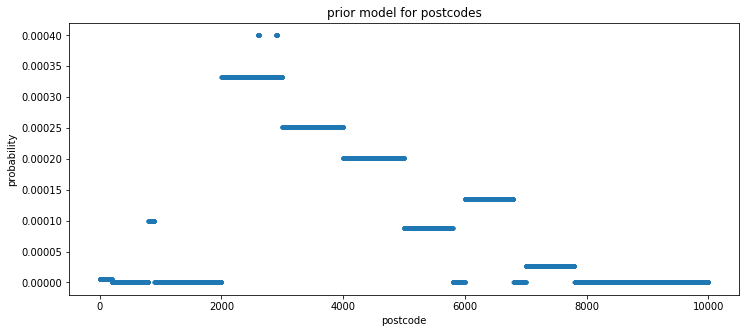

In [62]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(samplespace, p, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')
plt.title('prior model for postcodes');

### Incorporating more prior knowledge

We now show how to incorporate the prior knowledge that 40% of all mail
goes to the following CBD postcodes:

In [63]:
CBD_POSTCODES = {2000, 2001, 3000, 3001, 4000, 4001, 5000, 5001, 6000, 6001}

In [64]:
def in_cbd(postcodes):
    return [postcode in CBD_POSTCODES for postcode in postcodes]

In [65]:
features2 = features + [in_cbd]

In [66]:
k2 = np.c_[k, 0.25]

In [67]:
k2

array([[0.999, 0.32 , 0.252, 0.201, 0.071, 0.108, 0.021, 0.01 , 0.016,
        0.25 ]])

In [68]:
assert len(features2) == k2.shape[1]

In [70]:
model2 = MinDivergenceModel(features2, samplespace, vectorized=True)

In [71]:
model2.fit(k2)

MinDivergenceModel(algorithm='CG',
                   features=[<function is_valid at 0x191de3f620>,
                             <function in_given_state.<locals>.in_state at 0x191de3f7b8>,
                             <function in_given_state.<locals>.in_state at 0x191de3f8c8>,
                             <function in_given_state.<locals>.in_state at 0x191de3f950>,
                             <function in_given_state.<locals>.in_state at 0x191de3f9d8>,
                             <function in_given_state.<locals>.in_state at 0x191de3fa60>,
                             <function in_given_state.<locals>.in_state at 0x191de3fae8>,
                             <function in_given_state.<locals>.in_state at 0x191de3fb70>,
                             <function in_given_state.<locals>.in_state at 0x191de3fbf8>,
                             <function in_cbd at 0x1a1fd72048>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=array([   0,    

In [72]:
p2 = model2.probdist()

Text(0, 0.5, 'probability')

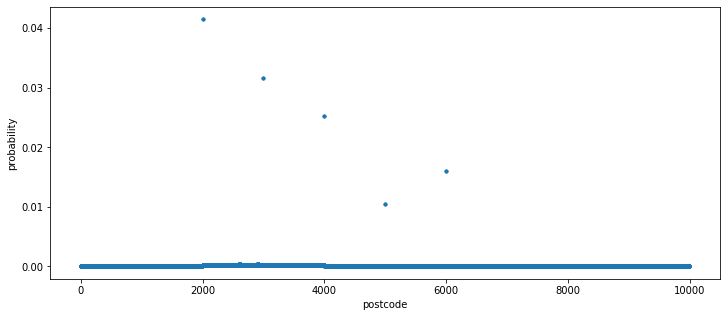

In [73]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(samplespace, p2, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

We can see more by using a logarithmic vertical axis:

Text(0, 0.5, 'probability')

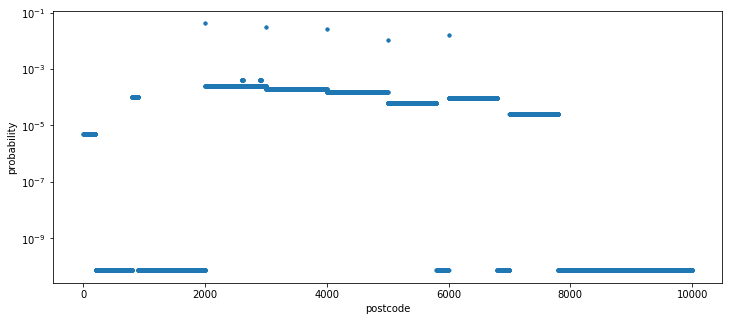

In [74]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.semilogy(samplespace, p2, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

### Tests

In [75]:
np.allclose(model2.expectations(), k2)

True

### More prior knowledge: CBD, inner suburbs, outer suburbs, regional centres

To incorporate this information:

- Within each state xxxx, 80% of mail goes to x0xx and x1xx (metropolitan city areas and suburbs).

we can do this:

In [76]:
def which_ring(postcodes):
    """
    Returns
    -------
    0 if postcode is x0xx
    100 if postcode is x1xx
    200 if postcode is x2xx
    ... otherwise
    """
    return [postcode % 1000 - postcode % 100 for postcode in postcodes]

In [77]:
which_ring([1234, 800, 2900, 3000, 2001, 2099, 3122])

[200, 800, 900, 0, 0, 0, 100]

In [78]:
def in_city_metropolitan_area(postcodes):
    return [ring == 0 or ring == 100 for ring in which_ring(postcodes)]

In [79]:
in_city_metropolitan_area([3136, 3122, 2001])

[True, True, True]

In [80]:
features3 = features2 + [in_city_metropolitan_area]

In [81]:
model3 = MinDivergenceModel(features3, samplespace, vectorized=True)

In [82]:
k3 = np.c_[k2, 0.8]

In [83]:
model3.fit(k3)

MinDivergenceModel(algorithm='CG',
                   features=[<function is_valid at 0x191de3f620>,
                             <function in_given_state.<locals>.in_state at 0x191de3f7b8>,
                             <function in_given_state.<locals>.in_state at 0x191de3f8c8>,
                             <function in_given_state.<locals>.in_state at 0x191de3f950>,
                             <function in_given_state.<locals>.in_state at 0x191de3f9d8>,
                             <function in_given_state.<locals>.in_state at 0x...
                             <function in_given_state.<locals>.in_state at 0x191de3fae8>,
                             <function in_given_state.<locals>.in_state at 0x191de3fb70>,
                             <function in_given_state.<locals>.in_state at 0x191de3fbf8>,
                             <function in_cbd at 0x1a1fd72048>,
                             <function in_city_metropolitan_area at 0x1a1fd72510>],
                   matrix_format='csr_ma

In [84]:
model3.expectations() - k3

array([[ 8.91286980e-08,  7.09513867e-08, -2.67813774e-07,
        -4.83883646e-08,  2.16201648e-07, -2.29478660e-07,
        -2.28077362e-07,  2.19798010e-09, -1.16173796e-07,
         1.83962300e-07,  4.32173284e-07]])

In [85]:
np.allclose(model3.expectations(), k3, atol=1e-5)

True

In [86]:
p3 = model3.probdist()

Text(0, 0.5, 'probability')

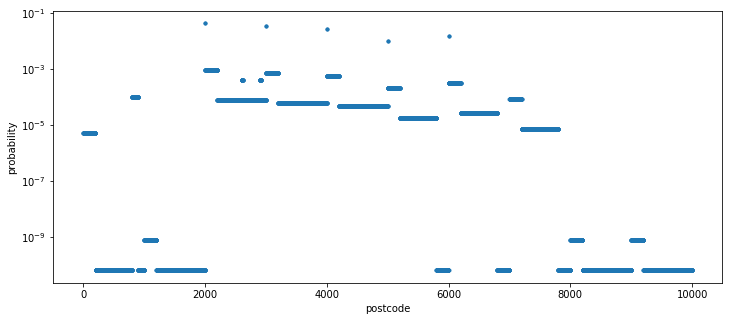

In [87]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.semilogy(samplespace, p3, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

### Now see if we can tweak the first model to be equivalent to `model2` by adding one new constraint and minimizing KL divergence from `model1`.

In [125]:
model4 = MinDivergenceModel([in_cbd], samplespace, model.log_probdist(), )

In [126]:
k4 = np.array([0.25], ndmin=2)

In [129]:
model4.fit(k4)

MinDivergenceModel(algorithm='CG',
          features=[<function in_cbd at 0x117d40598>],
          matrix_format='csr_matrix',
          prior_log_probs=array([-12.20625, -12.20625, ..., -22.54429, -22.54429]),
          samplespace=array([   0,    1, ..., 9998, 9999], dtype=uint16),
          vectorized=True, verbose=0)

In [130]:
model4.expectations()

array([ 0.26999354])

In [131]:
p4 = model4.probdist()

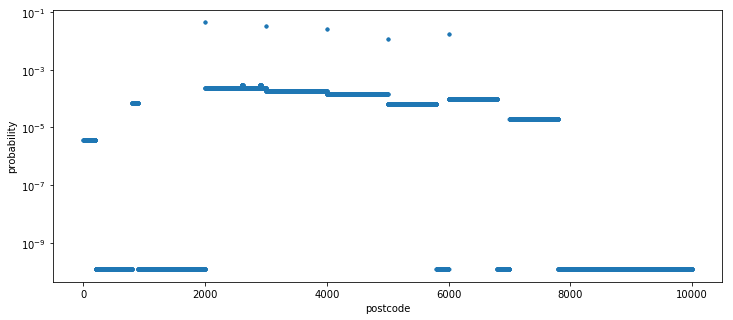

In [132]:
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.semilogy(samplespace, p4, '.', )
axes.set_xlabel('postcode')
axes.set_ylabel('probability')

No. The result is different because the process is different. We are no longer asserting the same constraints as before -- we are only asserting one single constraint. So this will in general have higher entropy than the more constrained model.